In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import gudhi as gd
from matplotlib.pyplot import figure
import simplex_classes as sc


### Change of this Version
In V4 we calculated connected components of vertices, adding them to the 0-Simplices for every integer time step.
We also visualised the 2-simplices in the plot of the filtration.
However, there I noticed that the int_filt value is incorrect: I have initialised it by dimension, rather than the actual filtration value. 

The plan for this version:
- Fix the int_filt value
- See if the rest, in particular the connected component stuff, still works
- look at the birth representative of a homology class, add up its crossing vectors and assign them to the correct connected component. 
- create a data frame where we can keep track of these vectors. 

# Functions 

### Generating Random Point Cloud
This function generates a uniformly distributed point cloud in the $[0,1]^2$ unit square of N points. 

In [2]:
def gen_points(N=5):
    """
    Generates N random points in [0,1]x[0,1] square,
    outputted as Nx2 numpy array, each row containing x and y coordinate.
    """
    return np.array([[rd.random(),rd.random()] for i in range(N)])


### Sublist Function
This is an auxillary function.
Given a list contain sublists, this function takes the kth element of each sublist and creates a new list from it. 

In [3]:
def k_sub(lst,k=0):
    """
    Takes list lst containing a sequence of sublists and 
    returns list of the first elements of each sublist
    """
    return [item[k] for item in lst]

### Plot Point Cloud
This function takes a 2d point cloud and plots the Delauney triangulation. It shows the whole $[-1,2]^2$ square, which we need for calculating the periodic case. 

In [33]:


def plot_complex(vertices, alpha=float("inf"), size=8):
    """
    Takes vertices as Nx2 numpy array and alpha value.
    Plots (non-periodic) 2-dim complex up to threshold alpha.
    
    size ... determines size of plot. 
    """
    
    alpha_complex = gd.AlphaComplex(vertices.reshape(-1,2))
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=alpha)

    filt = k_sub(simplex_tree.get_filtration())
    filt.sort(key = len)
    
    # cut into different dimensions of simplex
    # dimension is upper bounded by 2
    simp_0 = []
    simp_1 = []
    simp_2 = []
    cut = 0
    dim = 0
    
    
    for simp in filt:
        if len(simp) == 1:
            simp_0.append(simp)
        if len(simp) == 2:
            simp_1.append(simp)
        if len(simp) == 3:
            simp_2.append(simp)
   

    figure(figsize=(size,size), dpi=80)
    # plot points
    plt.scatter(vertices[:,0],vertices[:,1], color='black')
    
    # plot lines
    for [i,j] in simp_1:
        plt.plot((vertices[i,0],vertices[j,0]), (vertices[i,1],vertices[j,1]), color='#527da2')
    
    # plot triangles
    for [i,j,k] in simp_2:
        plt.fill((vertices[i,0],vertices[j,0],vertices[k,0]), (vertices[i,1],vertices[j,1],vertices[k,1]), color='#fcb73d')
    

    
    # plot unit square
    # (x1,x2), (y1,y2)
    plt.plot((0,0,1,1,0), (0,1,1,0,0), color = 'black')
    
    # plot transparent layer to grey out the repeating tiles, if there are any
    # this assumes we are in the periodic case with a right angle unit square repetition 
    plt.fill((-1,2,2,1,1,0,0,2,2,-1,-1), (2,2,0,0,1,1,0,0,-1,-1,2), color='white',alpha=0.8)
    
    """# annotate the vertices
    for i in simp_0:
        plt.annotate(str(i), xy=(vertices[i,0],vertices[i,1]), xycoords='data')
    """
    # This annotation is useless, because it gives the numbering of the duplicated simplices, not the numbering of our periodic simplices
    plt.gca().set_aspect('equal')
    
    
    
    


### Duplicatig Point Cloud to 3x3 Tile
This function takes a point cloud, for example the one given by gen_points(), and copies it 9 times. This is necessary for computing the periodic homology. 

In [34]:
def torus_copy(points, a=1,b=1):
    """
    Takes point set on axb rectangle (lower left vertex centered at origin)
    and creates 8 copies surrounding it.
    
    Returns new_points, containing original points and 8 offset copies.
    """
    
    N = np.shape(points)[0]
    new_points = np.zeros((9,N,2)) # 3x3 square numbered from left top to bottom right, Z-pattern
    #new_points[5,:,:] = points
    
    i = 0 
    for x in [-a,0,a]:
        for y in [-b,0,b]:
            transl = np.array([[x,y] for counter in range(N)])
            new_points[i,:,:] = points + transl
            i += 1
            
    return new_points.reshape(-1,2)

 
# Origially I thought it was smart to store which square we are in by setting a third coordinate
# However, at this point I am not using it, which is why I use reshape at the very end.


### Auxillary Function: Two coordinates are equivalent
This is an auxiliary function. It is used in identify().

On the 3x3 grid we want to check if two coordinates are equivalent, meaning that they are only shifted by an integer vector. Mod 1 (or mod a) doesn't work here, because it takes a smallest positive representative of the class, while we want the smallest absolute value representative. This function outputs this number.

In [35]:
def equiv_num(x1,x2,a=1):
    """
    Checks if 'x1=x2 mod 1', where we always want to take 
    the representative with the smallest absolute value. 
    
    Beware that though we can change 1 to a, if we are on a rectangle we will 
    have to consider different values of a depending on the direction we are looking at. 
    """
    z1 = abs(x1 - x2)
    z2 = abs(x1 - x2 + a)
    z3 = abs(x1 - x2 - a)
    return min(z1,z2,z3)

### Check Bound
This function looks at a point and checks if it is in the given 2d interval. If so, it outputs True, otherwise False.

In [7]:
def check_bound(point, xmin=0, xmax=1, ymin=0, ymax=1):
    x = point[0]
    y = point[1]
    if x >= xmin and x < xmax and y >= ymin and y < ymax:
        return True
    else:
        return False

In [8]:
def order_vertex(n1, coord1, n2, coord2):
    # Takes two vertices n1, n2 by integer values and 
    # their repsective coordinates coord1 and coord2
    # and outputs the integers and coordinates coorsponding 
    # to the lexicographic order of the coordinates
    
    [x1,y1] = coord1
    [x2,y2] = coord2
    if x1 < x2 or (x1 == x2 and y1 < y2):
        #left
        nl = n1
        xl = x1 
        yl = y1

        #right
        nr = n2
        xr = x2
        yr = y2

    else:
        #left
        nl = n2
        xl = x2
        yl = y2

        #right
        nr = n1
        xr = x1
        yr = y1
        
    return nl, [xl,yl], nr, [xr,yr]

In [9]:
def crossing_vector(coord,xmin=0,xmax=1,ymin=0,ymax=1):
    # Takes a coordinate coord=[x,y] and calculates the boundary vector,
    # under the assumption that it is the right vertex of a 1-simplex, 
    # and any such vertex can only lie in an adjacent cell of the main cell
    """
    Note that, even though I have xmin and ymin as variables here, they don't actually appear in the code.
    So if this becomes relevant, it should be included here in some places ...
    """
    xr = coord[0]
    yr = coord[1]
    
    if check_bound([xr,yr], xmax=xmax, ymax=ymax): # both points in unit cell
        vector = [0,0]

    elif check_bound([xr-xmax,yr], xmax=xmax, ymax=ymax): # right point is right of unit cell
        vector = [1,0]

    elif check_bound([xr,yr-ymax], xmax=xmax, ymax=ymax): # right point is above of unit cell
        vector = [0,1]

    elif check_bound([xr,yr+ymax], xmax=xmax, ymax=ymax): # right point is below unit cell
        vector = [0,-1]

    elif check_bound([xr-ymax, yr-ymax], xmax=xmax, ymax=ymax): # right point is right above unit cell (upper diagonal)
        vector = [1,1]

    else: # right point is right below the unit cell (lower diagonal)
        vector = [1,-1]

    return np.array(vector)

### Dimension Split Function

In [10]:

def dim_split(filt):
    # takes list of simplices with filtration values, i.e. with elements ([3,2], 0.123)
    # outputs 4 lists by splitting the original one by dimension
    simp_0 = []
    simp_1 = []
    simp_2 = []
    simp_3 = []
    
    for (simp, val) in filt:
        p = len(simp)-1
        
        if p == 0:
            simp_0.append((simp,val))
        if p == 1:
            simp_1.append((simp,val))
        if p == 2:
            simp_2.append((simp,val))
        if p == 3:
            simp_3.append((simp,val))
    return simp_0, simp_1, simp_2, simp_3

### Calculate Periodic Filtration from Duplicated Point Cloud

In [11]:

def periodic_filtration(N, points, alpha=float("inf"), a=1, b=1):
    # N is the number of points in main cell
    # points is a numpy array with the coordinates of all points, including copies
    
    # these are the side lengths of the unit cell
    # I only added these pretty late, so changing those blindly will lead to errors
    # But if you see places where "1" should rather be the length of the cell-sides, 
    # use these variables
    
    
    alpha_complex = gd.AlphaComplex(points)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=alpha)
    filtration = simplex_tree.get_filtration()
    
    
    # unidentified simplices split by dimension
    simp0, simp1, simp2, simp3 = dim_split(filtration)
    
    
    # for the 0-simplices we need 
    # the vertices (as numbers from 1 to N, i.e. [4]), 
    # the integer filtration value (i.e. 4), 
    # the continuous filtration value (i.e. 0.234)
    # and the coordinates (i.e. [0.5,0.81])
    
    Simplices_0 = []
    Simplices_1 = []
    Simplices_2 = []
    Simplices_3 = []
    identify_list = []
    eps = 1e-5
    
    """
    This list is too long, because we are taking the length of the original filtration,
    not the one of the periodic filtration.
    Either I figure out how to modify the placeholder-list-length, 
    or I initialise this later?
    For the moment more space is better than less. 
    """
    cc_l_ph = [0 for i in range(len(filtration))] # connected component list placeholder
    
    int_filt_value = 0
    
    for i in range(len(simp0)):
        simp, filt_value = simp0[i]
        
        # check if this is a 0-simplex we actually want
        # for that it has to be in the unit cell / axb cell
        coord = alpha_complex.get_point(i)

        if check_bound(coord,xmax=a,ymax=b): # point lies inside main cell
            Simplices_0.append(sc.Simplex0D([int_filt_value], int_filt_value, filt_value, coord,cc_l_ph))
            int_filt_value +=1
      
    
    
    # build identification list for later reference when building higher simplices
    for i in range(len(simp0)):
        simp, filt_value = simp0[i]
        coord = np.array(alpha_complex.get_point(i))

        for Simplex in Simplices_0: # looking for the point in the unit cell this corresponds to              
            other_coord = Simplex.coords
                
            if (equiv_num(coord[0],other_coord[0],a=a)<eps) and (equiv_num(coord[1],other_coord[1],a=b)<eps):
                identify_index = Simplex.int_filt
                
        identify_list.append([i, identify_index])
        
    
    # for the 1-simplices we need
    # the vertices (as numbers from 1 to N, i.e. [4, 7]), 
    # the integer filtration value (i.e. 12 (> N)), 
    # the continuous filtration value (i.e. 0.583)
    # the crossing vector (i.e. np.array([0,0]))
    # the vertices ordered lexicographically (i.e. 7)
    
    for i in range(len(simp1)):
        simp, filt_value = simp1[i]
        
        # check what the leftmost vertex is
        n0 = simp[0]
        n1 = simp[1]
        coord0 = alpha_complex.get_point(n0)
        coord1 = alpha_complex.get_point(n1)
        
        nl, coordl, nr, coordr = order_vertex(n0, coord0, n1, coord1)
        
        # Check if leftmost vertex is in unit cell
        if check_bound(coordl, xmax=a, ymax=b):
            # Calculate crossing vector
            cross_vec = crossing_vector(coordr,xmax=a,ymax=b)
            
            # identify the old vertices with the newly numerated ones!!!!! 
            # both for simplex, as well as for ordered vertices
            
            nl_new = (identify_list[nl])[1]
            nr_new = (identify_list[nr])[1]
            
            
            
            lex_ordered_simp = [Simplices_0[nl_new], Simplices_0[nr_new]]
            int_ordered_simp = sorted([nl_new,nr_new])
            
            Simplices_1.append(sc.Simplex1D(int_ordered_simp, int_filt_value, filt_value, cross_vec,lex_ordered_simp))
            
            int_filt_value +=1
    
    
    # for the 1-simplices we need
    # the vertices (as numbers from 1 to N, i.e. [1, 3, 6]), 
    # the integer filtration value (i.e. 24), 
    # the continuous filtration value (i.e. 0.583)
    # the boundary 1-simplices given by their integer filtration values (i.e. [12,15,20])
    
    for i in range(len(simp2)):
            simp, filt_value = simp2[i]

            # how can we find the correct 1-simplices?

            # if we have the vertices of the 2-simplex, we can look for 1-simplices which have two of these boundary points
            # since we only keep 2-simplices with their left-most point in the main cell
            # we can calculate the crossing vectors and then uniquly identify 2 out of 3 boundary elements

            # for the last edge, we have to 
            # - take the middle and the rightmost point,
            # - shift them such that the middle point is now in the main cell
            # - calculate the crossing vector of these shifted points
            # this is then the crossing vector of the last edge, and we can again identify
            # the correct 1-simplex using the vertices and the crossing vector
                
                
            [n1, n2, n3] = simp
            coord1 = alpha_complex.get_point(n1)
            coord2 = alpha_complex.get_point(n2)
            coord3 = alpha_complex.get_point(n3)
            
            # ordering vertices
            a0 = n1
            b0 = n2
            c0 = n3
            a0_coord = coord1
            b0_coord = coord2
            c0_coord = coord3
            
            a1, a1_coord, b1, b1_coord = order_vertex(a0, a0_coord, b0, b0_coord)
            a2, a2_coord, c1, c1_coord = order_vertex(a1, a1_coord, c0, c0_coord)
            b2, b2_coord, c2, c2_coord = order_vertex(b1, b1_coord, c1, c1_coord)
            # a2 is the leftmost, b2 is the middle and c2 is the rightmost coordinate, 
            # or a2 < b2 < c2 in lexicographical order
            
            
            # only if a2 is in the main cell do we continue
            if check_bound(a2_coord, xmax=a, ymax=b): 

                # the vertices are not yet in the naming convention we have chosen
                # so we rename them using identify_list
                for i in range(len(identify_list)):
                    new_name = (identify_list[i])[1]
                    if i == a2:
                        a2 = new_name
                    if i == b2:
                        b2 = new_name
                    if i == c2:
                        c2 = new_name


                # first boundary element from a2 to b2
                verts_1  = sorted([a2,b2])
                cr_vec_1 = crossing_vector(b2_coord,xmax=a,ymax=b)

                # second boundary element from a2 to c2
                verts_2  = sorted([a2,c2])
                cr_vec_2 = crossing_vector(c2_coord,xmax=a,ymax=b)

                # third boundary element from b2 to c2
                shift    = crossing_vector(b2_coord,xmax=a,ymax=b)
                verts_3  = sorted([b2,c2])
                cr_vec_3 = crossing_vector([c2_coord[0]-shift[0], c2_coord[1]-shift[1]])
                
                for j in range(len(Simplices_1)):
                    Simplex = Simplices_1[j]
                    verts = Simplex.verts
                    cv    = Simplex.cv
                    
                    
                    if (verts[0] == verts_1[0]) and (verts[1] == verts_1[1]) and (np.linalg.norm(cv-cr_vec_1)<eps):
                        bound_1 = Simplex
                    if (verts[0] == verts_2[0]) and (verts[1] == verts_2[1]) and (np.linalg.norm(cv-cr_vec_2)<eps):
                        bound_2 = Simplex
                    if (verts[0] == verts_3[0]) and (verts[1] == verts_3[1]) and (np.linalg.norm(cv-cr_vec_3)<eps):
                        bound_3 = Simplex

                Simplices_2.append(sc.Simplex2D( sorted([a2,b2,c2]), int_filt_value, filt_value, [Simplices_0[a2],Simplices_0[b2],Simplices_0[c2]], [bound_1,bound_2,bound_3]))
                int_filt_value += 1
                
    
   
    periodic_filt = []
    
    periodic_filt_0 = [(Simplex.verts, Simplex.cont_filt) for Simplex in Simplices_0]
    periodic_filt += periodic_filt_0
    
    periodic_filt_1 = [(Simplex.verts, Simplex.cont_filt) for Simplex in Simplices_1]
    periodic_filt += periodic_filt_1
    
    periodic_filt_2 = [(Simplex.verts, Simplex.cont_filt) for Simplex in Simplices_2]
    periodic_filt += periodic_filt_2
    
    periodic_filt_3 = [(Simplex.verts, Simplex.cont_filt) for Simplex in Simplices_3]
    periodic_filt += periodic_filt_3

    f = lambda some_tuple: some_tuple[1]
    periodic_filt.sort(key = f)
    
    
    # right now, the integer filtration value is wrong, because it is first sorted by dimension,
    # only afterwards by actuall filtration value. 
    # periodic_filt tells us how many steps we actually have
    # and by searching for the index of (Simplex.verts, Simplex.cont_filt) in periodic_filt, 
    # we should get the integer filtration value
    
    for Simplex in Simplices_0:
        int_filt = periodic_filt.index((Simplex.verts, Simplex.cont_filt))
        Simplex.update_int_filt(int_filt)
    for Simplex in Simplices_1:
        int_filt = periodic_filt.index((Simplex.verts, Simplex.cont_filt))
        Simplex.update_int_filt(int_filt)
    for Simplex in Simplices_2:
        int_filt = periodic_filt.index((Simplex.verts, Simplex.cont_filt))
        Simplex.update_int_filt(int_filt)
    for Simplex in Simplices_3:
        int_filt = periodic_filt.index((Simplex.verts, Simplex.cont_filt))
        Simplex.update_int_filt(int_filt)
    
    
    return periodic_filt, [Simplices_0, Simplices_1, Simplices_2, Simplices_3]
    


In [12]:
def plot_filtration(p_filt, S, a=1, b=1, size=8, reps=[], max_step=float("inf")):
    
    # This function takes a periodic filtration p_filt and Simplices as given by periodic_filtration(), 
    # and outputs a labeled plot of the complex on the torus. 
    # reps allows for the highlighting of a representative cycle by giving a list of 1-simplices
    Simplices_0 = S[0]
    Simplices_1 = S[1]
    Simplices_2 = S[2]
    Simplices_3 = S[3]
    norm = lambda x: np.linalg.norm(x)
    """
    maybe we can manage to
    a) get representatives into this as well
    b) get a slider in here to go through the filtration
    """
    
    intercept = lambda t,X,Y: [t*X[0] + (1-t)*X[1], t*Y[0] + (1-t)*Y[1]]
    
    
    figure(figsize=(size,size), dpi=80)
   
    # 0-Simplices
    eps = 1e-2 # offset of annotation from point
    for Simp in Simplices_0:
        if Simp.int_filt <= max_step:
            [x,y] = Simp.coords
            plt.scatter(x,y, color='black')
            plt.annotate(str(Simp.verts[0]), xy=(x+eps,y+eps), xycoords='data')
    
    
    
    # 1-Simplices
    
    zero = np.array([0,0])
    e1   = np.array([1,0]) * a
    e2   = np.array([0,1]) * b
    
    
    eps = 0#1e-2 # offset for annotations
    for Simp in Simplices_1:
        if Simp.int_filt <= max_step:
            rand_color = (np.random.rand(),np.random.rand(),np.random.rand()) #color='#527da2'
            vec = Simp.cv
            [xl,yl] = (Simp.vert0).coords
            [xr,yr] = (Simp.vert1).coords
            [xr,yr] = [xr+vec[0],yr+vec[1]] # these are the coordinates in the unit cell, the label vectors tell us how to correctly shift them for the plot
            X = [xl,xr]
            Y = [yl,yr]

            annotation = str(Simp.verts)+" ("+str(Simp.int_filt)+")"

            if Simp in reps:
                highlight = True
            else: 
                highlight = False

            # 1) those that don't cross the boundary
            if norm(vec - zero) == 0: 
                # annotate in middle of line
                plot_edge_and_annotate(X,Y,annotation=annotation,color=rand_color, eps=eps, highlight=highlight)



            # 2) those that connect to the right cell
            if norm(vec - e1) == 0: 
                # Calculate intercept with boundary
                t = (a-X[1]) / (X[0]-X[1])
                [x_intercept, y_intercept] = intercept(t,X,Y)

                # plot copy from left point to intercept
                plot_edge_and_annotate([X[0],x_intercept],[Y[0],y_intercept],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)

                # plot copy from intercept to right point
                plot_edge_and_annotate([x_intercept-a, X[1]-a],[y_intercept,Y[1]],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)



            # 3) those that connect to the upper cell
            if norm(vec - e2) == 0: 
                # Calculate intercept with boundary
                t = (b-Y[1])/(Y[0]-Y[1])
                [x_intercept, y_intercept] = intercept(t,X,Y)

                # plot copy from left point to intercept
                plot_edge_and_annotate([X[0],x_intercept],[Y[0],y_intercept],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)

                # plot copy from intercept to right point
                plot_edge_and_annotate([x_intercept, X[1]],[y_intercept-b,Y[1]-b],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)




            # 4) those that connect to the lower cell
            if norm(vec - (-e2)) == 0:
                # Calculate intercept with boundary
                t = (0-Y[1])/(Y[0]-Y[1])
                [x_intercept, y_intercept] = intercept(t,X,Y)

                # plot copy from left point to intercept
                plot_edge_and_annotate([X[0],x_intercept],[Y[0],y_intercept],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)

                # plot copy from intercept to right point
                plot_edge_and_annotate([x_intercept, X[1]],[y_intercept+b,Y[1]+b],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)





            # 5) those that connect to the upper right cell    
            if norm(vec - e2 - e1) == 0: 
                # plot again a shifted copy
                X1 = (X[0]-a, X[1]-a)
                Y1 = (Y[0]-b, Y[1]-b)
                plt.plot(X1, Y1,  color = rand_color)

                # check case
                v1 = np.array([X[0],Y[0]])
                v2 = np.array([X[1],Y[1]])
                p  = np.array([a,b]) # the right upper corner of the cell
                v1p  = p - v1
                v1v2 = v2 - v1
                M = np.zeros((2,2))
                M[:,0] = v1p
                M[:,1] = v1v2

                # Case 5.1: we traverse the upper cell
                if np.linalg.det(M) > 0:
                    print("Case 5.1: we traverse the upper cell")
                    t1 = (b-Y[1])/(Y[0]-Y[1])
                    t2 = (a-X[1])/(X[0]-X[1])

                    [xi1, yi1] = intercept(t1,X,Y)
                    [xi2, yi2] = intercept(t2,X,Y)

                    # starting edge
                    plot_edge_and_annotate([X[0],xi1],[Y[0],yi1],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)

                    # passing edge
                    plot_edge_and_annotate([xi1, xi2],[yi1-b,yi2-b],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)

                    # ending edge
                    plot_edge_and_annotate([xi2-a,X[1]-a],[yi2-b,Y[1]-b],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)


                # Case 5.2: we traverse the right cell (or exactly through the corner)
                if np.linalg.det(M) <= 0:
                    print("Case 5.2: we traverse the right cell (or exactly through the corner)")
                    t1 = (a-X[1])/(X[0]-X[1])
                    t2 = (b-Y[1])/(Y[0]-Y[1])

                    [xi1, yi1] = intercept(t1,X,Y)
                    [xi2, yi2] = intercept(t2,X,Y)


                    # starting edge
                    plot_edge_and_annotate([X[0],xi1],[Y[0],yi1],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)

                    # passing edge
                    plot_edge_and_annotate([xi1-a, xi2-a],[yi1,yi2],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)

                    # ending edge
                    plot_edge_and_annotate([xi2-a, X[1]-a],[yi2-b,Y[1]-b],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)


            # 6) those that connect to the lower right cell
            if norm(vec - (-e2) - e1) == 0: 
                # plot again a shifted copy
                X1 = (X[0]-a, X[1]-a)
                Y1 = (Y[0]-b, Y[1]-b)
                plt.plot(X1, Y1,  color = rand_color)

                """
                Similar case distinction as in the upper right cell case
                """
                # check case
                v1 = np.array([X[0],Y[0]])
                v2 = np.array([X[1],Y[1]])
                p  = np.array([a,0]) # the right upper corner of the cell
                v1p  = p - v1
                v1v2 = v2 - v1
                M = np.zeros((2,2))
                M[:,0] = v1p
                M[:,1] = v1v2

                # Case 6.1: we traverse the right cell
                if np.linalg.det(M) > 0:
                    print("Case 6.1: we traverse the right cell")
                    t1 = (a-X[1])/(X[0]-X[1])
                    t2 = (0-Y[1])/(Y[0]-Y[1])

                    [xi1, yi1] = intercept(t1,X,Y)
                    [xi2, yi2] = intercept(t2,X,Y)



                    # starting edge
                    plot_edge_and_annotate([X[0],xi1],[Y[0],yi1],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)

                    # passing edge
                    plot_edge_and_annotate([xi1-a, xi2-a],[yi1,yi2],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)

                    # ending edge
                    plot_edge_and_annotate([xi2-a, X[1]-a],[yi2+b, Y[1]+b],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)



                # Case 6.2: we traverse the lower cell (or exactly through the corner)
                if np.linalg.det(M) <= 0:

                    print("Case 6.2: we traverse the lower cell (or exactly through the corner)")
                    t1 = (0-Y[1])/(Y[0]-Y[1])
                    t2 = (a-X[1])/(X[0]-X[1])

                    [xi1, yi1] = intercept(t1,X,Y)
                    [xi2, yi2] = intercept(t2,X,Y)



                    # starting edge
                    plot_edge_and_annotate([X[0],xi1],[Y[0],yi1],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)

                    # passing edge
                    plot_edge_and_annotate([xi1, xi2],[yi1+b,yi2+b],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)

                    # ending edge
                    plot_edge_and_annotate([xi2-a,X[1]-a],[yi2+b,Y[1]+b],annotation=annotation,color=rand_color, eps=eps, highlight=highlight)


    
   
    color = "#ffde91"
    for Simp in Simplices_2:
        if Simp.int_filt <= max_step:
            # triangle with leftmost corner in main cell
            
            [Edge1, Edge2, Edge3] = Simp.boundary
            p1 = np.array(Edge1.vert0.coords)
            p2 = np.array(Edge1.vert1.coords) + Edge1.cv
            p3 = np.array(Edge2.vert1.coords) + Edge2.cv
            
            plot_triangle(p1,p2,p3,color)
            
            # the easiest way to plot the other triangle copies is to just blindly 
            # plot 9 offsets if any crossing vector is non-zero
            
            if norm(Edge1.cv) + norm(Edge2.cv)!= 0: 
                plot_triangle(p1,p2,p3,color,vec1= e1)
                plot_triangle(p1,p2,p3,color,vec1=-e1)
                plot_triangle(p1,p2,p3,color,vec1= e2)
                plot_triangle(p1,p2,p3,color,vec1=-e2)
                plot_triangle(p1,p2,p3,color,vec1= e1,vec2= e2)
                plot_triangle(p1,p2,p3,color,vec1=-e1,vec2= e2)
                plot_triangle(p1,p2,p3,color,vec1= e1,vec2=-e2)
                plot_triangle(p1,p2,p3,color,vec1=-e1,vec2=-e2)
            
    """
    
    # plot triangles
    for [i,j,k] in simp_2:
        plt.fill((vertices[i,0],vertices[j,0],vertices[k,0]), (vertices[i,1],vertices[j,1],vertices[k,1]), color='#fcb73d')
    

    
    """
    
    
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.gca().set_aspect('equal')
    plt.show()
    
    
    
    


In [13]:
def plot_edge_and_annotate(X,Y,annotation="",color="black", eps=0 , highlight=False):
    # auxiliary function for plot_filtration
    # X is x-coordinates of start- and endpoint of edge
    # Y is y-coordinates of start- and endpoint of edge
    
    if highlight == True:
        lw=5
        color = "blue"
    else: 
        lw=1.5

    plt.plot([X[0],X[1]], [Y[0],Y[1]],  color = color, linewidth=lw)
    Xmean = (X[0]+X[1])/2 
    Ymean = (Y[0]+Y[1])/2

    plt.annotate(annotation, xy=(Xmean-eps,Ymean))


In [14]:
 def plot_triangle(p1,p2,p3,color,vec1=0,vec2=0):
        # auxiliary function for plot_filtration
        # p1, p2, p3 are vertices of triangle to be plotted
        v1 = p1 - vec1 - vec2 
        v2 = p2 - vec1 - vec2
        v3 = p3 - vec1 - vec2
        plt.fill((v1[0],v2[0],v3[0]), (v1[1],v2[1],v3[1]), color=color)
        

### Calculate Boundary Maps from Filtration

In [15]:
def boundary_matrix(S0, S1, S2, S3=[]):
    
    # takes the lists of simplices and outputs a boundary matrix
    # Note that the boundary matrix is sorted by dimension, so we are considered with 
    # the index of a simplex as seen from Si, not as given by .int_filt
    # step 1: we initialise matrix of dimension s0+s1+s2(boundaries) x s1+s2+s3
    
    
    D = np.zeros((len(S0+S1+S2),len(S0+S1+S2+S3)))
    
    # The 0-Simplices all appear at the beginning and are already ordered by their usual index
    
    d0 = len(S0)
    d1 = len(S1)
    d2 = len(S2)
    
    for j in range(d1):
        for i in S1[j].verts:
            D[i,j+d0] += 1
    
    for j in range(d2):
        for i in range(d1):
            if S1[i] in S2[j].boundary:
                D[i+d0,j+d0+d1] += 1
    
    """
    The 3rd boundary matrix is missing at this point. Process should be the same, though.
    """
    
    return np.mod(D,2)

### Check lowest element

In [16]:
def check_low(column):
    """ 
    This function returns the index of the lowest element of the given column.
    If the column is empty, it returns -1.
    """
    low = -1
    m = len(column)
    for i in range(0,m):
        if column[m-1-i]==1:
            low = m-1-i
            break
    return low


### Perform Column Reduction

In [17]:
def column_red(D, exhaustive=False): 
     
    # This function takes a binary boundary matrix and performs column reduction on it.
    # It returns the reduced matrix "R", as well as a list of its pivot elements "pivots". 
    # Zero columns are encoded as -1. 
    """
    We want to implement exhaustive reduction at some point. 
    """
    # D is numpy array of size mxn
    (m,n) =  D.shape # rows, column
    R = D.copy()
    V = np.identity(n)
    
    pivots = []
    
    for i in range(0,n):
        # look at current pivot 
        low = check_low(R[:,i])
        
        # check if this is already a pivot element
        while (low in pivots) and (low != -1): 
            # while pivot is taken, perform matrix reduction on R
            
            j = pivots.index(low)
            R[:,i]= (R[:,i] + R[:,j]) % 2
            V[:,i]= (V[:,i] + V[:,j]) % 2
            
            # get new pivot
            low = check_low(R[:,i]) 
            
           
            # don't forget to reduce mod 2
        
        pivots.append(low)
        
    
    return pivots, R, V



### Calculate Persistence from Boundary Maps

In [18]:

def PH(filt, S):
    # Takes a list containing sublists of filtered simplices by dimension
    # and calculates the dimensions of Cn, Bn, Zn and Hn, 
    # as well as persistence pairs pp and representatives reps of homology classes
    
    d=2 # this is the dimension we are working in
        # right now we are only on the square, so d=2
    
    D = boundary_matrix(S[0], S[1], S[2], S[3])
    
    dim_list = [len(S[i]) for i in range(0,d+1)]
    
    #pivots = [-1 for i in range(dim_list[0])]
    dCn = np.zeros(d+1)
    dZn = np.zeros(d+1)
    dBn = np.zeros(d+1)
    dHn = np.zeros(d+1)
    
    pivots, R, V = column_red(D)
    
  
    
    
    
    
    inf = float('inf')
    
    
    # Calculate the vector space dimensions, in particular Betti numbers
    m = 0
    for i in range(0,d+1):
        # extract dimensions of vector spaces
        dCn[i]   = dim_list[i]
        dZn[i]   = pivots[m:m+dim_list[i]].count(-1)
        dBn[i-1] = dCn[i] - dZn[i]
        m += dim_list[i]
        
    for i in range(0,d+1):
        dHn[i]   = dZn[i] - dBn[i]
        
   
    
    pp_int = [] # list of persistence pairs
    
    # calculate persistence pairs
    for j in range(D.shape[1]):# looking at the jth column
        
        # determine dimension
        for k in range(len(dim_list)): 
                if j < sum(dim_list[0:k+1]) and j >= sum(dim_list[0:k]):
                    dim = k
        """
        Here we are again taking the numbering first by dimension, then by filtration.
        We need to reference the actuall int_filt of the respective simplices. 
        This should work by looking at the jth k-simplex and taking its int_filt value.
        """
        # if jth column is 0 --> new cycle
        if pivots[j] == -1:
            pds = sum([len(S[cnt]) for cnt in range(dim)]) # previous dimension needed to be subtracted 
            a = (S[dim])[j-pds].int_filt
            pp_int.append((dim, (a,inf)))
            
        # if column is non-zero --> death of class (that must have been born previously)
        else:
            pds1 = sum([len(S[cnt]) for cnt in range(dim)]) # previous dimension needed to be subtracted 
            pds2 = sum([len(S[cnt]) for cnt in range(max(0,dim-1))])  # previous dimension needed to be subtracted 
            
            a = (S[dim-1])[pivots[j]-pds2].int_filt
            b = (S[dim])[j-pds1].int_filt
            pp_int.remove((dim-1, (a, inf)))
            pp_int.append((dim-1, (a,b)))
        
    
    # sort by beginning of interval
    firstof = lambda l: (l[1])[0]
    pp_int.sort(key=firstof)
    
    
    # persistance pairs with continuous values
    pp_cont = disc2cont_pp(pp_int, filt)

    # Caculate representatives (contains also information of pp_int and pp_cont)
    pairs_w_reps = representatives(V, pp_int, pp_cont, S) 
    
  
    
    
    for timestep in range(len(filt)):
        for v in S[0]:
            v.calc_cc(S, timestep)
    
    
    return dCn, dZn, dBn, dHn, pp_int, pp_cont, pairs_w_reps

In [19]:
def representatives(V, pp_int, pp_cont, S):

    # The j-th column of V encodes the columns in ∂ that add up to give the j-th column in R.  (p. 182 / 194)
    m,n = V.shape
    rep_list = []
    
    
    for index in range(len(pp_int)):
        (dim,(a,b)) = pp_int[index]
        (dim,(a_cont,b_cont)) = pp_cont[index]
        
        
        for i in range(len(S[dim])):
            if S[dim][i].int_filt == a:
                j = i
                break
                
        pds = sum([len(S[cnt]) for cnt in range(dim)])
        j += pds
        
        # We want to take the birth representative,
        # meaning we look at the column of the cycle being born
        
        jcolumn = V[:,j]
        reps = []
        
        for i in range(0,m): 
            if jcolumn[i] == 1: 
                S_index = i - pds
                Simplex = S[dim][S_index] 
                reps.append(Simplex)
        
        rep_list.append(sc.Persistence_Pair(dim, (a,b), (a_cont,b_cont), reps))
    
    

    return rep_list
    

In [20]:
def disc2cont_pp(pp, filt):
    """
    Takes the list of persistence pairs with discrete filtration values, as well as the original filtration,
    and outputs a list of peristence pairs with their smooth filtration values. 
    """
    pp_cont = []
    for (dim, (a,b)) in pp:
        a_cont = (filt[a])[1]
        
        if b != float("inf"):
            b_cont = (filt[b])[1]
        else:
            b_cont = float("inf")
            
        pp_cont.append((dim, (a_cont, b_cont)))
        
    return pp_cont

In [21]:
# Compute connected component of vertex at time i
"""
In ths version I don't track along the chain of 1-simplices given by V, 
I just take the other vertex we are being directly merged to by the new 1-simplex.

I'm a bit skeptical if this function is working properly. 
With the specific vertices I looked at, it seemed correct. 
However, the print-statements during the process made me question 
if everything is really going to way I want it to.
"""
def connected_component_rep(v,i,S0,S1, pivots):
    v_index = v.int_filt
    print("\niteration")
    relevant_pivots = pivots[:i+1] # including timestep i
    
    if v_index in relevant_pivots:
        j = relevant_pivots.index(v_index)
        edge = S1[j - len(S0)]
        print("vertex:",v_index)
        print(f"edge which has {v_index} as pivot: {edge.verts} ({edge.int_filt})")
        
        for vertex in edge.ord_verts:
            if vertex != v:
                v0 = connected_component_rep(vertex,i-1,S0,S1,pivots)
    else:
        v0 = v
    
    return v0

# Examples

In [22]:
from importlib import reload  
sc = reload(sc)

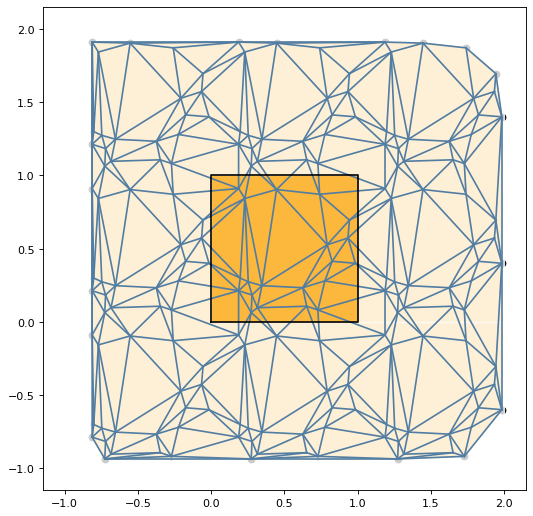

In [23]:
N = 20
points = gen_points(N)
extended_points =  torus_copy(points)
plot_complex(extended_points)

Chains:
[20. 60. 40.]

Cycles
[20. 41.  1.]

Boundaries
[19. 39.  0.]

Betti numbers
[1. 2. 1.]


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

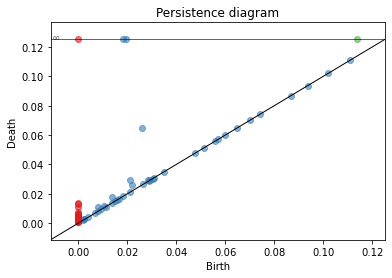

In [24]:
p_filt, S = periodic_filtration(N, extended_points)

dCn, dZn, dBn, dHn, pp_int, pp_cont, pairs_w_reps = PH(p_filt,S)
print("Chains:")
print(dCn)
print("\nCycles")
print(dZn)
print("\nBoundaries")
print(dBn)
print("\nBetti numbers")
print(dHn)
gd.plot_persistence_diagram(pp_cont)


The 24th persistence pair gets born at step 43 and dies at step 44. 
Its birth representative has a TOTAL crossing vector of [0 0].
At this point, the representative lies in the connected component of vertex 1.
Hence [0 0] contributes to the spanning family of vectors of component 1.



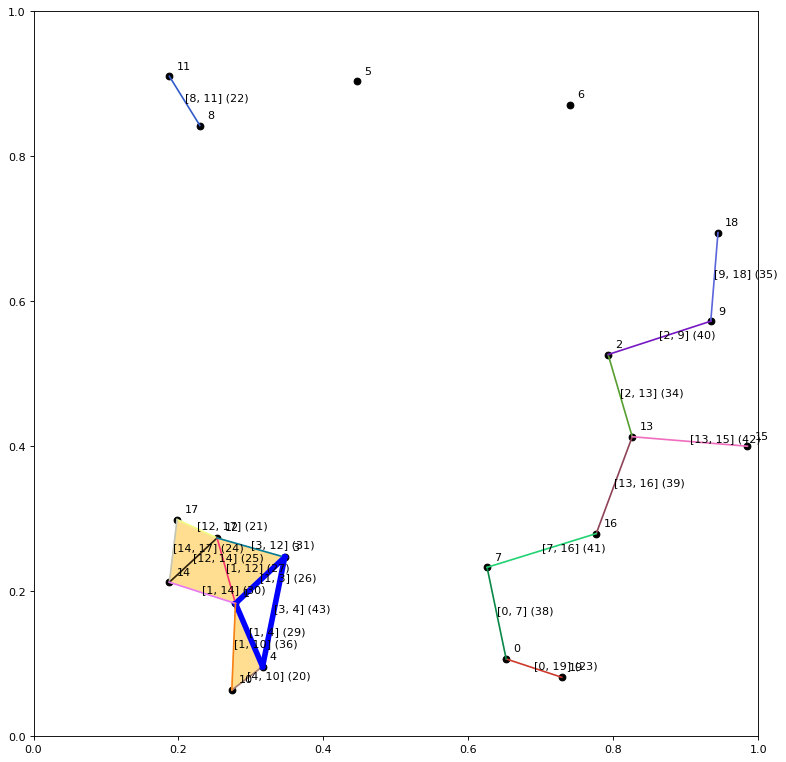

In [25]:
rep_num = N+4 # needs to be 1-dimensional, so generally >= N, but this could also be 2-dim
rep = pairs_w_reps[rep_num]
timestep = rep.start_int
pairs_w_reps[rep_num].calc_cc()
cc = rep.cc[timestep]
tcv = rep.return_cv(timestep)
print(f"""
The {rep_num}th persistence pair gets born at step {timestep} and dies at step {rep.end_int}. 
Its birth representative has a TOTAL crossing vector of {tcv}.
At this point, the representative lies in the connected component of vertex {cc}.
Hence {tcv} contributes to the spanning family of vectors of component {cc}.
""")

#for vertex in range(N):
#    print(f"vertex {vertex}, component {(S[0])[vertex].cc[timestep]}")
plot_filtration(p_filt, S, a=1, b=1, size=12, reps=rep.reps, max_step=timestep)


To-Do 
Add up the total crossing vectors using the knowledge of connected components. 


In [26]:
# Make list of lists
# First index gives timestep
# Second index gives connected component (0 to N-1)
# This then contains all the vectors contributing to this connected component. 

time_list = [[[] for j in range(N)] for i in range(len(p_filt))]

for time in range(len(p_filt)):
    for pair in pairs_w_reps:
        if pair.dim == 1 and pair.start_int <= time and pair.end_int > time:
            pair.calc_cc()
            cc = pair.cc[time]
            (time_list[time])[cc].append(pair.return_cv(time))
        

for time in range(N,len(p_filt)):
    print(f"\ntime {time}:")
    for comp in range(N):
        print(f"Component {comp} -- Lambda_0 spanned by: {(time_list[time])[comp]}")


time 20:
Component 0 -- Lambda_0 spanned by: []
Component 1 -- Lambda_0 spanned by: []
Component 2 -- Lambda_0 spanned by: []
Component 3 -- Lambda_0 spanned by: []
Component 4 -- Lambda_0 spanned by: []
Component 5 -- Lambda_0 spanned by: []
Component 6 -- Lambda_0 spanned by: []
Component 7 -- Lambda_0 spanned by: []
Component 8 -- Lambda_0 spanned by: []
Component 9 -- Lambda_0 spanned by: []
Component 10 -- Lambda_0 spanned by: []
Component 11 -- Lambda_0 spanned by: []
Component 12 -- Lambda_0 spanned by: []
Component 13 -- Lambda_0 spanned by: []
Component 14 -- Lambda_0 spanned by: []
Component 15 -- Lambda_0 spanned by: []
Component 16 -- Lambda_0 spanned by: []
Component 17 -- Lambda_0 spanned by: []
Component 18 -- Lambda_0 spanned by: []
Component 19 -- Lambda_0 spanned by: []

time 21:
Component 0 -- Lambda_0 spanned by: []
Component 1 -- Lambda_0 spanned by: []
Component 2 -- Lambda_0 spanned by: []
Component 3 -- Lambda_0 spanned by: []
Component 4 -- Lambda_0 spanned by

In [27]:

# To Do: Get rid of possibly identical vectors in list of crossing vectors

In [29]:
time_list

[[[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 [[],
  [],
  [],
  [],
  [],
  